# data load

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('./data.csv', encoding='euc-kr',index_col=0)
name = data.index
X = np.array(data)
print(X)

[[-433.08963112 -427.09716201 -412.3403501  ...   -9.35074932
   -12.65299636   -9.37304958]
 [-292.80556927 -286.82925949 -294.08002594 ...   10.11966571
     7.60417296    5.66313308]
 [-402.00670746 -379.15618944 -346.8464879  ...   27.81986429
    22.57617986   13.50105067]
 ...
 [-424.90479609 -416.24115942 -405.02232115 ...   35.78577191
    39.22160974   28.01107229]
 [-146.67593008  -96.64004764  -63.01583943 ...   -0.9838669
     1.17957637    0.50246968]
 [-269.28249665 -256.58016883 -240.0789487  ...    5.75756209
    11.50294759   14.46294348]]


# subsampling 가능성 확인

In [ ]:
#자기상관 확인
import matplotlib.pyplot as plt
plt.plot(X_train[0][:200], 'o-')
plt.show()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(X_train[0][:200])
plt.show()

In [ ]:
# reshape 해서 20장 만든 다음에 클래스별 표본 20개해서 120개 클래스에 대해서 판별분석???
#1장씩 따로 차원 축소 한 뒤, 다시 붙인다.

In [ ]:
51760/20

In [81]:
X = X.reshape(20*126,2588)
X.shape

(2520, 2588)

# scaling
스케일링 이후 벡터간 동질성 감소, 분류에 좋다.

In [82]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(X)
scaled_X = scale.transform(X)
X_train = scaled_X
X_test = scaled_X
scaled_X.shape

(2520, 2588)

# AE 학습

In [ ]:
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K

# configure
encoding_dim = 400
input_val = Input(shape=(2588,))


# layers
encoded = Dense(encoding_dim, activation='relu')(input_val)
decoded = Dense(2588, activation='sigmoid')(encoded)


# Models
autoencoder = Model(input_val, decoded) # autoencoder

encoder = Model(input_val, encoded) # encoder

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input)) # decoder

In [ ]:

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))


# train autoencoder
autoencoder.compile(optimizer='adam', loss='mse', metrics=[rmse])
autoencoder.fit(X, X,
                epochs=10,
                batch_size=10,
                shuffle=True)


# encoding result
encoded_imgs = encoder.predict(X)

In [ ]:
df=pd.DataFrame(encoded_imgs)

In [ ]:
# 20개 피쳐에서 클러스터링 가능여부

In [84]:
df = list(map(lambda x : np.mean(x),scaled_X))
df = np.array(df)
df = df.reshape(int(2520/20),20)

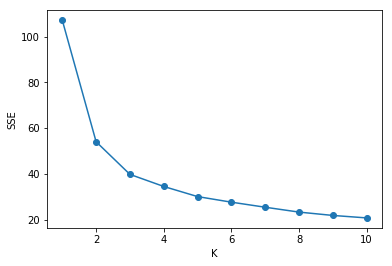

In [85]:
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
def elbow(X):
    sse = []

    for i in range(1,11):
        km = KMeans(n_clusters=i,algorithm='auto', random_state=42)
        km.fit(X)
        sse.append(km.inertia_)

    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.savefig('fig.png', dpi=300)
    plt.show()
    

elbow(df)


In [89]:
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt

k = 2
# create model and prediction
model = KMeans(n_clusters=k,algorithm='auto')
model.fit(df)
predict = pd.DataFrame(model.predict(df))
predict.columns=['predict']

print(predict)
count=[]
for i in range(k):
    count.append(sum(predict['predict']==i))

string = 'abcdefghijklmnopqr'
    
for i in range(k):
    print('{}번째 군집은 {}개'.format(i+1,count[i]))
    predict['predict'] = predict['predict'].replace(i,string[i])

     predict
0          1
1          0
2          0
3          1
4          0
..       ...
121        0
122        0
123        1
124        1
125        0

[126 rows x 1 columns]
1번째 군집은 78개
2번째 군집은 48개


            pc1        pc2  singer cluster
0     -0.283157  -0.374065    10cm       b
1      0.318027  -0.324613    Buzz       a
2    -0.0150099  0.0424891   Crush       a
3       -1.1709   0.367198  K.Will       b
4      0.905214 -0.0711134     KCM       a
..          ...        ...     ...     ...
121   -0.101904 -0.0876366      환희       a
122     0.12714  -0.107577     황인욱       a
123   -0.534678  -0.176481      효린       b
124   -0.906513   0.431965      휘성       b
125 -0.00815434  -0.639354      휘인       a

[126 rows x 4 columns]


,pc1,pc2,singer,cluster
1,0.318027,-0.324613,Buzz,a
2,-0.0150099,0.0424891,Crush,a
4,0.905214,-0.0711134,KCM,a
5,0.24924,0.119913,Zion.T,a
6,1.21604,0.0238506,jk김동욱,a
...,...,...,...,...
117,0.494643,0.195313,하림,a
120,1.27113,0.188942,현진영,a
121,-0.101904,-0.0876366,환희,a
122,0.12714,-0.107577,황인욱,a


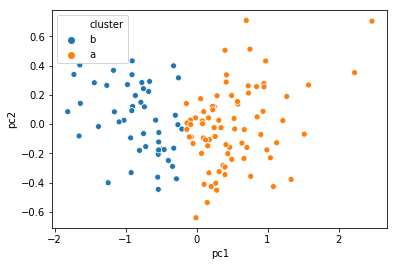

In [90]:
from sklearn.preprocessing import StandardScaler
import numpy as np


#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(df)
new = np.c_[pc,name, predict]
df_1  = pd.DataFrame(new,columns=['pc1','pc2','singer','cluster'])
print(df_1)

#polting
import seaborn as sns
sns.scatterplot(x='pc1',y='pc2',hue = 'cluster',data =df_1)
#plt.savefig('fig3.png', dpi=300)
df_1[df_1['cluster']=='a']